## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

import copy

import data

2022-11-16 10:52:20.670796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 10:52:20.828580: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Prepare the data

In [2]:
# 4000 averages of 50
# 4000 averages of 1000

# Since we only need images from the dataset to encode and decode, we
# won't use the labels.

# 2000 training, 1000 validation, 1000 test
_train_noisy, _val_noisy, _test_noisy = \
    data.loadData_tri(ns=50, N_train=2000, N_val=1000, N_test=1000)
_train_target, _val_target, _test_target = \
    data.loadData_tri(ns=1000, N_train=2000,  N_val=1000, N_test=1000)

theory_cov = np.loadtxt("samples2/xi_new_boss_zs_z0p61_lin_ximulti_covar.dat")

# Normalize and reshape the data
train_noisy = data.preprocess_cov(_train_noisy, theory_cov=theory_cov)
val_noisy = data.preprocess_cov(_val_noisy, theory_cov=theory_cov)
test_noisy = data.preprocess_cov(_test_noisy, theory_cov=theory_cov)

train_target = data.preprocess_cov(_train_target, theory_cov=theory_cov)
val_target = data.preprocess_cov(_val_target, theory_cov=theory_cov)
test_target = data.preprocess_cov(_test_target, theory_cov=theory_cov)

#target_data = preprocess_theory(theory_cov)

# Display the train data and a version of it with added noise
# display(train_data, train_data)

cov_len = len(theory_cov)

## Build the autoencoder

In [3]:
"""Technically Keras already provides this,
but the API is a mess when it comes to
the layer / activation function distinction"""
from tensorflow.keras import backend as K
def ReLU(x):
    return K.relu(x, alpha=0.001)

In [4]:
### Aliases to keep the code compact
universal_kernel = (3, 3)
universal_padding = "same"
universal_dropRate = 0.05
universal_numStrides = 1

def conv(in_, filters, activation_in):
    return layers.Conv2D(filters, universal_kernel,
        activation=activation_in, padding=universal_padding)(in_)

def tConv(in_, filters, activation_in):
    return layers.Conv2DTranspose(filters, universal_kernel,
        strides=universal_numStrides, activation=activation_in,
        padding=universal_padding)(in_)

def drop(in_):
    return tf.keras.layers.Dropout(universal_dropRate)(in_)

In [5]:
input_ = layers.Input(shape=(cov_len, cov_len, 1))

def get_autoencoders(function):
    print("Initializing self autoencoder...")
    
    a_self = Model(input_, function)
    a_self.compile(optimizer="adam", loss="mean_squared_error")

    a_self.fit(
        x=train_noisy,
        y=train_noisy,
        epochs=5,
        batch_size=15,
        shuffle=True,
        validation_data=(val_noisy, val_noisy),
    )
    
    print("Initializing target autoencoder...")
    
    a_target = Model(input_, function)
    a_target.compile(optimizer="adam", loss="mean_squared_error")
    
    a_target.fit(
        x=train_noisy,
        y=train_target,
        epochs=5,
        batch_size=15,
        shuffle=True,
        validation_data=(val_noisy, val_target),
    )
    
    return a_self, a_target

In [6]:
def build_layers(inner_act, last_act, drops=True):
    # Encoder
    x = conv(input_, 64, last_act)
    if drops:
        x = drop(x)
    x = conv(x, 32, inner_act)
    if drops:
        x = drop(x)
    # Decoder
    x = tConv(x, 32, inner_act)
    if drops:
        x = drop(x)
    x = tConv(x, 64, inner_act)
    if drops:
        x = drop(x)
    x = conv(x, 1, last_act)
    return x

old = build_layers("relu", "sigmoid", drops=False)
paper = build_layers(ReLU, "tanh", drops=True)
nondropper = build_layers(ReLU, "tanh", drops=False)
sigmoidLast = build_layers(ReLU, "sigmoid", drops=True)
nonleaker = build_layers("relu", "tanh", drops=True)

# Autoencoder
print("\n\nOld function:")
a_old_self, a_old_target = get_autoencoders(old)

print("\n\nPaper's function:")
a_paper_self, a_paper_target = get_autoencoders(paper)

print("\n\nNondropper function:")
a_nondropper_self, a_nondropper_target = get_autoencoders(nondropper)

print("\n\nSigmoid as last activation function:")
a_sigmoidLast_self, a_sigmoidLast_target = get_autoencoders(sigmoidLast)

print("\n\nNonleaker function:")
a_nonleaker_self, a_nonleaker_target = get_autoencoders(nonleaker)

2022-11-16 10:52:36.300169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.




Old function:
Initializing self autoencoder...
Epoch 1/5
134/134 [==============================] - 33s 245ms/step - loss: 0.0741 - val_loss: 0.0707
Epoch 2/5
134/134 [==============================] - 36s 266ms/step - loss: 0.0705 - val_loss: 0.0710
Epoch 3/5
134/134 [==============================] - 37s 273ms/step - loss: 0.0711 - val_loss: 0.0711
Epoch 4/5
134/134 [==============================] - 36s 268ms/step - loss: 0.0709 - val_loss: 0.0711
Epoch 5/5
134/134 [==============================] - 36s 268ms/step - loss: 0.0709 - val_loss: 0.0711
Initializing target autoencoder...
Epoch 1/5
134/134 [==============================] - 37s 276ms/step - loss: 0.0485 - val_loss: 0.0485
Epoch 2/5
134/134 [==============================] - 36s 269ms/step - loss: 0.0485 - val_loss: 0.0485
Epoch 3/5
134/134 [==============================] - 36s 268ms/step - loss: 0.0485 - val_loss: 0.0485
Epoch 4/5
134/134 [==============================] - 36s 268ms/step - loss: 0.0485 - val_loss: 0.048

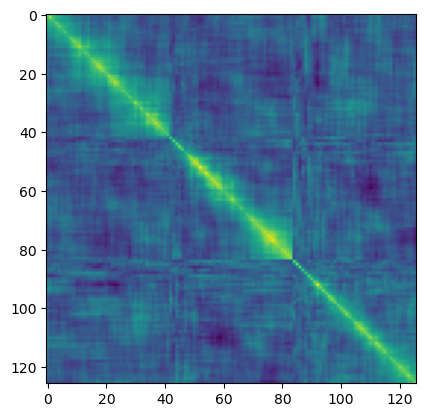

In [7]:
plt.imshow(train_noisy[0].reshape(cov_len, cov_len))

## Training and testing

32/32 [==============================] - 6s 192ms/step


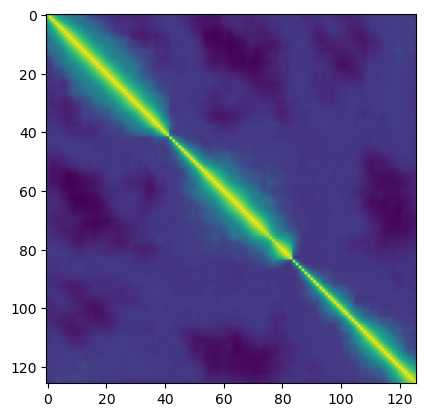

In [9]:
predictions = a_paper_target.predict(val_noisy)
plt.imshow(predictions[0].reshape(cov_len, cov_len))

32/32 [==============================] - 6s 192ms/step


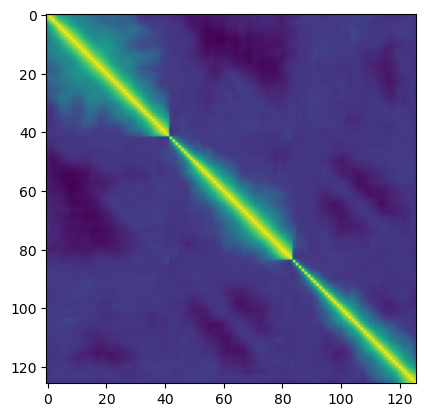

In [10]:
predictions = a_paper_target.predict(test_noisy)
plt.imshow(predictions[0].reshape(cov_len, cov_len))

In [11]:
"""
a_old_self, a_old_target = get_autoencoders(old)
a_paper_self, a_paper_target = get_autoencoders(paper)
a_nondropper_self, a_nondropper_target = get_autoencoders(nondropper)
a_sigmoidLast_self, a_sigmoidLast_target = get_autoencoders(sigmoidLast)
a_nonleaker_self, a_nonleaker_target = get_autoencoders(nonleaker)
"""

"""
a_old_self.save("a_old_self")
a_old_target.save("a_old_target")
a_paper_self.save("a_paper_self")
a_paper_target.save("a_paper_target")
a_nondropper_self.save("a_nondropper_self")
a_nondropper_target.save("a_nondropper_target")
a_sigmoidLast_self.save("a_sigmoidLast_self")
a_sigmoidLast_target.save("a_sigmoidLast_target")
a_nonleaker_self.save("a_nonleaker_self")
a_nonleaker_target.save("a_nonleaker_target")
"""

'\na_old_self.save("a_old_self")\na_old_target.save("a_old_target")\na_paper_self.save("a_paper_self")\na_paper_target.save("a_paper_target")\na_nondropper_self.save("a_nondropper_self")\na_nondropper_target.save("a_nondropper_target")\na_sigmoidLast_self.save("a_sigmoidLast_self")\na_sigmoidLast_target.save("a_sigmoidLast_target")\na_nonleaker_self.save("a_nonleaker_self")\na_nonleaker_target.save("a_nonleaker_target")\n'